# Open Source RAG - Leveraging Hugging Face Endpoints through LangChain

In the following notebook we will dive into the world of Open Source models hosted on Hugging Face's [inference endpoints](https://ui.endpoints.huggingface.co/).

The notebook will be broken into the following parts:

- 🤝 Breakout Room #2:
  1. Install required libraries
  2. Set Environment Variables
  3. Creating LangChain components powered by the endpoints
  4. Creating a simple RAG pipeline with [LangChain v0.2.0](https://blog.langchain.dev/langchain-v02-leap-to-stability/)

## Task 1: Install required libraries

Now we've got to get our required libraries!

We'll start with our `langchain` and `huggingface` dependencies.

> You don't need to run this cell if you're running the notebook locally.

In [95]:
#!pip install -qU langchain-huggingface langchain-community faiss-cpu

## Task 2: Set Environment Variables

We'll need to set our `HF_TOKEN` so that we can send requests to our protected API endpoint.

We'll also set-up our OpenAI API key, which we'll leverage later.



In [1]:
import os
import getpass

os.environ["HF_TOKEN"] = getpass.getpass("HuggingFace Write Token: ")

## Task 3: Creating LangChain components powered by the endpoints

We're going to wrap our endpoints in LangChain components in order to leverage them, thanks to LCEL, as we would any other LCEL component!

### HuggingFaceEndpoint for LLM

We can use the `HuggingFaceEndpoint` found [here](https://github.com/langchain-ai/langchain/blob/master/libs/community/langchain_community/llms/huggingface_endpoint.py) to power our chain - let's look at how we would implement it.

In [2]:
YOUR_LLM_ENDPOINT_URL = "https://dcrebqe18cydo729.us-east-1.aws.endpoints.huggingface.cloud"

In [ ]:
from langchain_community.llms import HuggingFaceEndpoint

hf_llm = HuggingFaceEndpoint(
    endpoint_url=f"{YOUR_LLM_ENDPOINT_URL}",
    task="text-generation",
    max_new_tokens=512,
    top_k=10,
    top_p=0.95,
    typical_p=0.95,
    temperature=0.01,
    repetition_penalty=1.03,
)

/tmp/ipykernel_32142/1022838628.py:3: LangChainDeprecationWarning: The class `HuggingFaceEndpoint` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEndpoint``.
  hf_llm = HuggingFaceEndpoint(
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Now we can use our endpoint like we would any other LLM!

In [4]:
hf_llm.invoke("Hello, how are you?")

" I am doing well, thanks for asking. I have been busy with work and other things, but I always make time for my blog. Today, I want to talk about something that is very important to me: mental health.\nAs you may know, I have been open about my struggles with anxiety and depression in the past. It's not something that I like to talk about, but it's something that I feel is important to share in order to help others who may be going through similar struggles.\nMental health is just as important as physical health, and it's something that we should all prioritize. Unfortunately, there is still a stigma surrounding mental health, and many people struggle to speak openly about their feelings and experiences.\nThat's why I want to use my platform to raise awareness and promote understanding of mental health. I believe that by talking openly and honestly about our struggles, we can break down the stigma and create a more supportive and compassionate community.\nSo, today I want to talk abou

Now we can add a RAG-style prompt using Llama 3 Instruct's prompt templating!

In [8]:
from langchain_core.prompts import PromptTemplate

RAG_PROMPT_TEMPLATE = """\
<|start_header_id|>system<|end_header_id|>
You are a helpful assistant. You answer user questions based on provided context. If you can't answer the question with the provided context, say you don't know.<|eot_id|>

<|start_header_id|>user<|end_header_id|>
User Query:
{query}

Context:
{context}<|eot_id|>

<|start_header_id|>assistant<|end_header_id|>
"""

rag_prompt = PromptTemplate.from_template(RAG_PROMPT_TEMPLATE)

Let's create a simple LCEL chain using our prompt template Runnable and our LLM Runnable.

In [9]:
rag_chain = rag_prompt | hf_llm

In [10]:
rag_chain.invoke({"query" : "Who old is Carl?", "context" : "Carl is a sweet dude, he's 40."})

'Carl is 40 years old.'

### HuggingFaceInferenceAPIEmbeddings

Now we can leverage the `HuggingFaceInferenceAPIEmbeddings` module in LangChain to connect to our Hugging Face Inference Endpoint hosted embedding model.

In [11]:
from langchain_huggingface.embeddings import HuggingFaceEndpointEmbeddings

YOUR_EMBED_MODEL_URL = "https://c87ybgo18epgba6d.us-east-1.aws.endpoints.huggingface.cloud"

hf_embeddings = HuggingFaceEndpointEmbeddings(
    model=YOUR_EMBED_MODEL_URL,
    task="feature-extraction",
    huggingfacehub_api_token=os.environ["HF_TOKEN"],
)

Let's build a simple cosine-similarity function to verify our endpoint is working as expected.

In [12]:
import numpy as np
from numpy.linalg import norm

def cosine_similarity(phrase_1, phrase_2):
  vec_1 = hf_embeddings.embed_documents([phrase_1])[0]
  vec2_2 = hf_embeddings.embed_documents([phrase_2])[0]
  return np.dot(vec_1, vec2_2) / (norm(vec_1) * norm(vec2_2))

Let's try a few examples below!

In [13]:
cosine_similarity("I love my fluffy dog!", "I adore this furry puppy!")

0.8903063446222079

In [15]:
cosine_similarity("I love my fluffy dog!", "Trekking across the arctic is tough work.")

0.6667445107282148

## Task 4: Preparing Data!

We'll start by loading some data from GitHub (Paul Graham's Essays) and then move to chunking them into manageable pieces!

First - let's grab the repository where the files live.

In [16]:
!git clone https://github.com/dbredvick/paul-graham-to-kindle.git

Cloning into 'paul-graham-to-kindle'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 36 (delta 3), reused 31 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (36/36), 2.35 MiB | 13.80 MiB/s, done.
Resolving deltas: 100% (3/3), done.


Next - we can load them using LangChain!

In [17]:
from langchain_community.document_loaders import TextLoader

document_loader = TextLoader("./paul-graham-to-kindle/paul_graham_essays.txt")
documents = document_loader.load()

Now, let's split them into 1000 character pieces.

In [18]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=30)
split_documents = text_splitter.split_documents(documents)
len(split_documents)

4265

Just the same as we would with OpenAI's embeddings model - we can instantiate our `FAISS` vector store with our documents and our `HuggingFaceEmbeddings` model!

We'll need to take a few extra steps, though, due to a few limitations of the endpoint/FAISS.

We'll start by embeddings our documents in batches of `32`.

> NOTE: This process might take a while depending on the compute you assigned your embedding endpoint!

In [20]:
from langchain_community.vectorstores import FAISS

for i in range(0, len(split_documents), 32):
  if i == 0:
    vectorstore = FAISS.from_documents(split_documents[i:i+32], hf_embeddings)
    continue
  vectorstore.add_documents(split_documents[i:i+32])

Next, we set up FAISS as a retriever.

In [21]:
hf_retriever = vectorstore.as_retriever()

## Task 5: Simple LCEL RAG Chain

Now we can set up our LCEL RAG chain!

> NOTE: We're not returning context for this example, and only returning the text output from the LLM.

In [22]:
from operator import itemgetter
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough

lcel_rag_chain = {"context": itemgetter("query") | hf_retriever, "query": itemgetter("query")}| rag_prompt | hf_llm

In [23]:
lcel_rag_chain.invoke({"query" : "What is the best part of Silicon Valley?"})

"According to the provided context, the best part of Silicon Valley is its proximity to a top-notch university, such as Stanford, which acts as a magnet to attract the best people from around the world. Additionally, the area's public transportation system, although not perfect, is considered good by American standards. However, the author suggests that the area could be improved by designing a town that prioritizes trains, bicycles, and pedestrian-friendly infrastructure over cars."

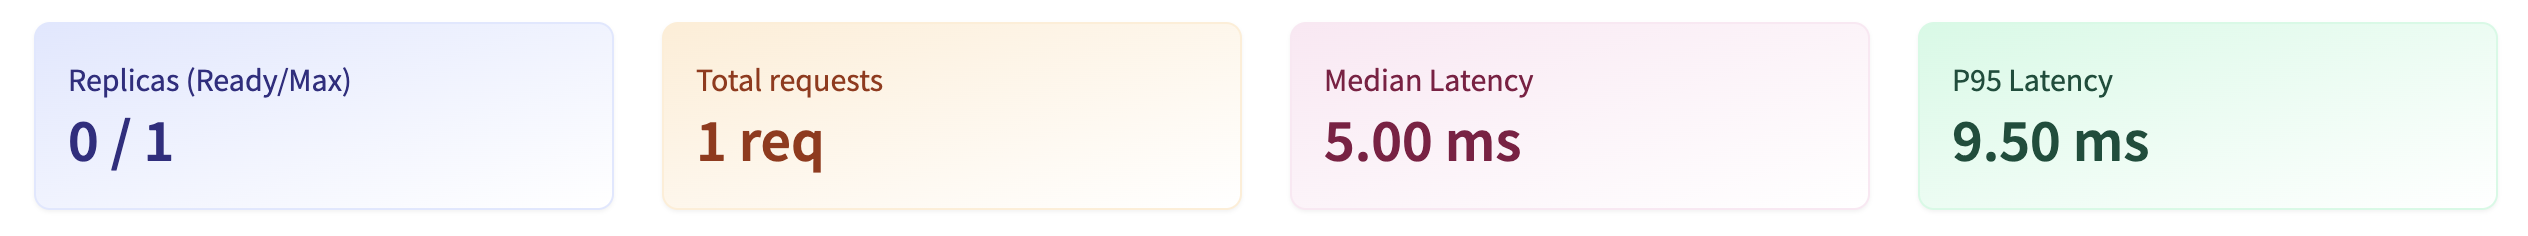
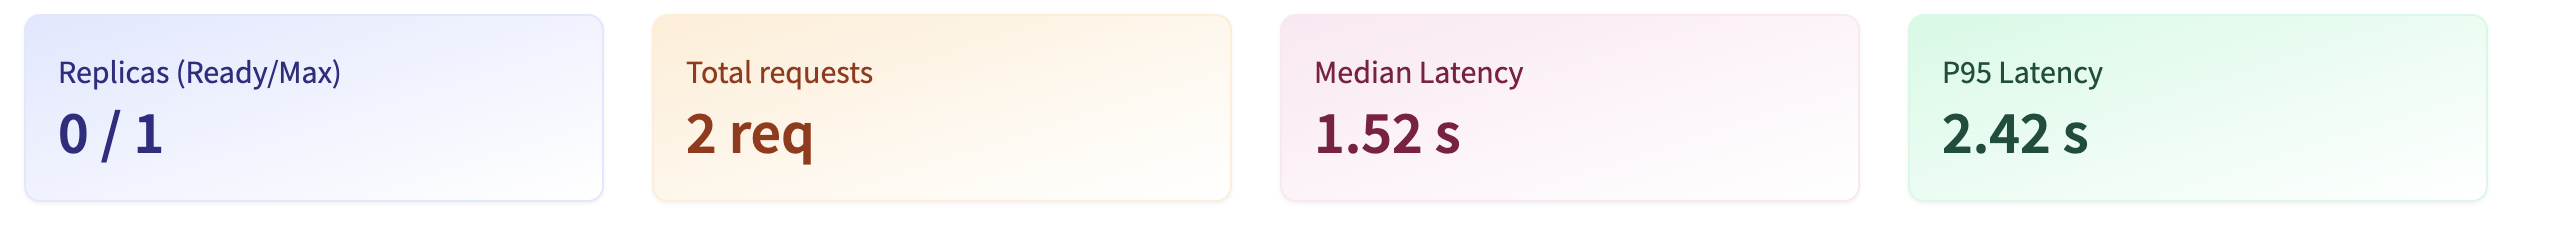